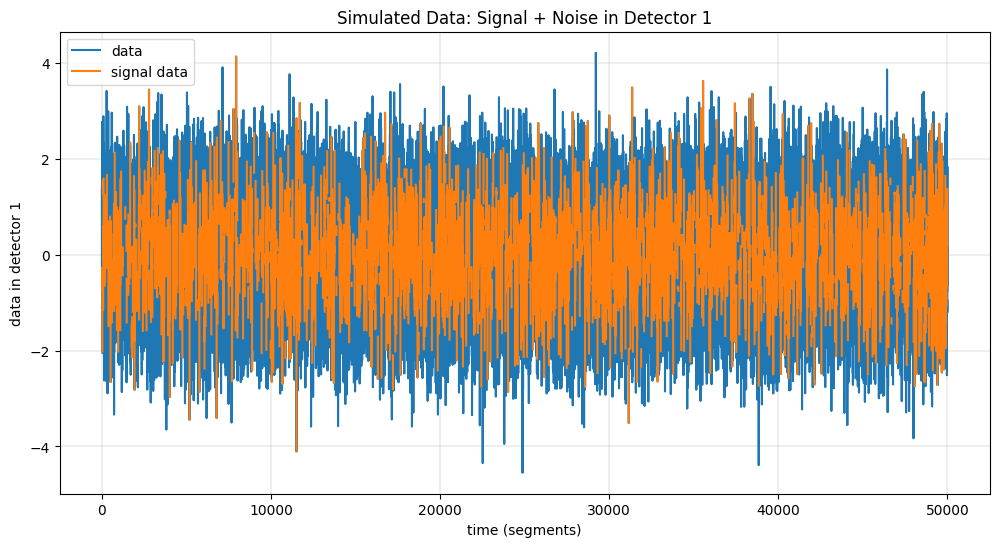

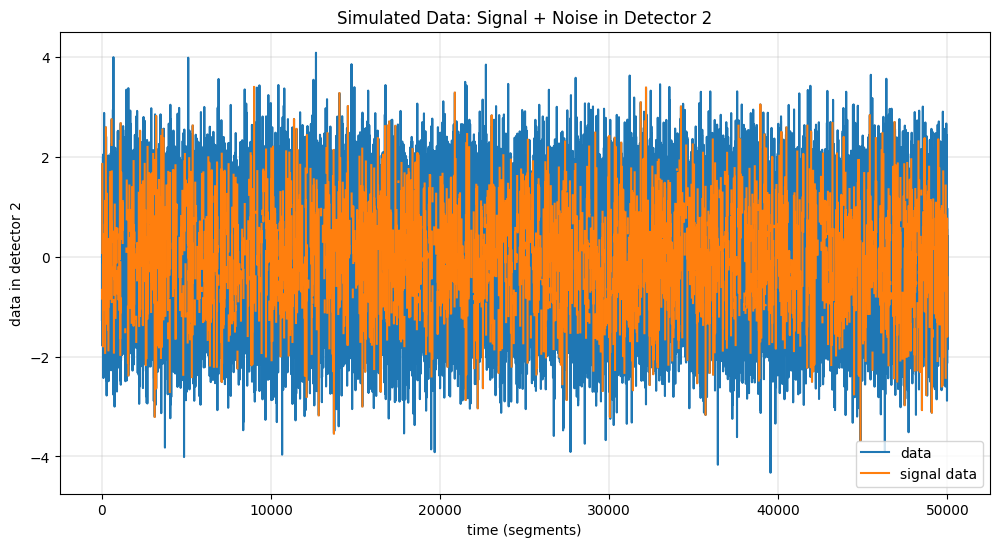

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
total_segments = 50000  # 总数据段数
signal_probability = 0.2  # 信号 Duty Cycle
sampling_rate = 4096  # 采样率
duration = 1  # 每段数据持续时间

# 噪声与信号的特性
noise_std_1 = 1.0  # 探测器1噪声标准差
noise_std_2 = 1.0  # 探测器2噪声标准差
signal_std = 0.3  # 信号标准差（两个探测器共享）

# 数据段初始化
data_detector_1 = np.zeros(total_segments)
data_detector_2 = np.zeros(total_segments)

# 随机生成信号段（信号出现为稀疏）
signal_mask = np.random.rand(total_segments) < signal_probability

# 生成共享信号 h
signal_h = np.zeros(total_segments)
signal_h[signal_mask] = np.random.normal(0, signal_std, size=np.sum(signal_mask))

# 为两个探测器添加独立噪声
data_detector_1 = signal_h + np.random.normal(0, noise_std_1, total_segments)
data_detector_2 = signal_h + np.random.normal(0, noise_std_2, total_segments)

# 构建信号数据，仅保留信号段的值，其余置为 NaN
signal_data_1 = np.full_like(data_detector_1, np.nan)
signal_data_2 = np.full_like(data_detector_2, np.nan)
signal_data_1[signal_mask] = data_detector_1[signal_mask]
signal_data_2[signal_mask] = data_detector_2[signal_mask]

# 绘制探测器1数据
plt.figure(figsize=(12, 6))
plt.plot(range(total_segments), data_detector_1, color="#1f77b4", linewidth=1.5, label="data")
plt.plot(range(total_segments), signal_data_1, color="#ff7f0e", linewidth=1.5, label="signal data")
plt.xlabel("time (segments)")
plt.ylabel("data in detector 1")
plt.title("Simulated Data: Signal + Noise in Detector 1")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

# 绘制探测器2数据
plt.figure(figsize=(12, 6))
plt.plot(range(total_segments), data_detector_2, color="#1f77b4", linewidth=1.5, label="data")
plt.plot(range(total_segments), signal_data_2, color="#ff7f0e", linewidth=1.5, label="signal data")
plt.xlabel("time (segments)")
plt.ylabel("data in detector 2")
plt.title("Simulated Data: Signal + Noise in Detector 2")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

In [2]:
# SNR 计算
N = len(data_detector_1)
Gamma_2 = np.mean(data_detector_1 * data_detector_2)

sigma_h2 = signal_std**2  # 信号方差（共享信号）
sigma_n1 = noise_std_1
sigma_n2 = noise_std_2

E_Gamma2 = signal_probability * sigma_h2
Var_Gamma2 = (sigma_n1**2 * sigma_n2**2) / N

snr = np.sqrt(E_Gamma2**2 / Var_Gamma2)
print(f"Calculated SNR: {snr:.3f}")
print(f"Expected Gamma_2 (E[Gamma_2]): {E_Gamma2:.6f}")
print(f"Variance of Gamma_2 (Var[Gamma_2]): {Var_Gamma2:.6f}")

Calculated SNR: 4.025
Expected Gamma_2 (E[Gamma_2]): 0.018000
Variance of Gamma_2 (Var[Gamma_2]): 0.000020


In [ ]:
# 联合概率密度计算（避免 overflow）
def joint_pdf(s1, s2, xi, sigma_n1, sigma_n2, sigma_h):
    h_values = np.linspace(-5 * sigma_h, 5 * sigma_h, 500)
    log_p_h = np.log(xi * norm.pdf(h_values, loc=0, scale=sigma_h) + 1e-12)
    log_p_joints = []
    
    for h in h_values:
        log_p_n1 = -0.5 * ((s1 - h) / sigma_n1)**2 - np.log(np.sqrt(2 * np.pi) * sigma_n1)
        log_p_n2 = -0.5 * ((s2 - h) / sigma_n2)**2 - np.log(np.sqrt(2 * np.pi) * sigma_n2)
        log_p_joints.append(log_p_h[np.where(h_values == h)[0][0]] + log_p_n1 + log_p_n2)
    
    log_p_joint_max = max(log_p_joints)
    log_p_sum = np.log(np.sum(np.exp(np.array(log_p_joints) - log_p_joint_max)))
    return log_p_joint_max + log_p_sum

# 优化 Duty Cycle
def optimize_duty_cycle(s1_data, s2_data, sigma_n1, sigma_n2, sigma_h, xi_range):
    log_likelihoods = []
    for xi in xi_range:
        log_likelihood = 0
        for s1, s2 in zip(s1_data, s2_data):
            log_likelihood += joint_pdf(s1, s2, xi, sigma_n1, sigma_n2, sigma_h)
        log_likelihoods.append(log_likelihood)
    max_index = np.argmax(log_likelihoods)
    return xi_range[max_index], log_likelihoods

# xi 从 0 到 1，观察是否存在局域峰值
xi_range = np.linspace(0, 1, 50)
optimal_xi, log_likelihoods = optimize_duty_cycle(data_detector_1, data_detector_2, noise_std_1, noise_std_2, signal_std, xi_range)

# 绘制对数似然值曲线
plt.figure(figsize=(10, 6))
plt.plot(xi_range, log_likelihoods, label="Log-Likelihood", color="blue")
plt.axvline(optimal_xi, color="red", linestyle="--", label=f"Optimal xi: {optimal_xi:.3f}")
plt.xlabel("Duty Cycle (xi)")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs Duty Cycle")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 偏度和峰度计算（基于高阶累积量）
signal_data_combined = data_detector_1 + data_detector_2
signal_data_mean = np.mean(signal_data_combined)
signal_data_std = np.std(signal_data_combined)

# 偏度
signal_skewness = np.sum(((signal_data_combined - signal_data_mean) / signal_data_std) ** 3) / len(signal_data_combined)

# 峰度
signal_kurtosis = np.sum(((signal_data_combined - signal_data_mean) / signal_data_std) ** 4) / len(signal_data_combined) - 3

# 打印偏度和峰度结果
print(f"Skewness of Signal Data (Cumulant-Based): {signal_skewness}")
print(f"Kurtosis of Signal Data (Cumulant-Based): {signal_kurtosis}")

# 输出最优 xi
print(f"Optimal Duty Cycle (xi): {optimal_xi:.3f}")